# 知識點 - 1
- 圖像增強的目的有兩點:
    1. 彌補資料不足
    2. 避免Overfitting
    
## Keras - ImageDataGenerator

以下為各項參數的預設值與常用參數的說明:
```python
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)
```
- `featurewise_center`：Boolean，以每一張特徵響應圖為單位將平均值設為0。
- `featurewise_std_normalization`: Boolean，以每一張特徵響應圖為單位將數值除以其標準差

上述兩步驟就是我們常見的 Standardization，其用途在於使不同的輸入影像有相似的資料分佈範圍，加快收斂速度，也較容易找到 Global Minimum。

- `zca_whitening: Boolean`，透過 ZCA 取出重要特徵 (詳見：[ZCA介紹](https://www.kaggle.com/nicw102168/exploring-zca-and-color-image-whitening))
- `rotation_range`：整數值，控制隨機旋轉角度
- `width_shift_range`：「浮點、整數、一維數」，圖像寬度上隨機偏移值
- `height_shift_range`：「浮點、整數、一維數」，圖像高度上隨機偏移值
- `shear_range`：浮點數，裁切範圍
- `zoom_range`：浮點數或範圍，隨機縮放比例
- `horizontal_flip`: Boolean，隨機水平翻轉
- `vertical_flip`:Boolean，隨機垂直翻轉
- `rescale`: 數值，縮放比例
- `dtype`：輸出資料型態

使用上非常簡單，直接參考[官方文件](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)最準確。



## 『本次練習目的』
  #### 熟悉Image Augmentation的實作方法
  #### 瞭解如何導入Imgae Augmentation到原本NN架構中

In [1]:
!pip install imgaug

In [2]:
import glob
import os
import pickle
import random
import time

import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## ImageDataGenerator 使用方法


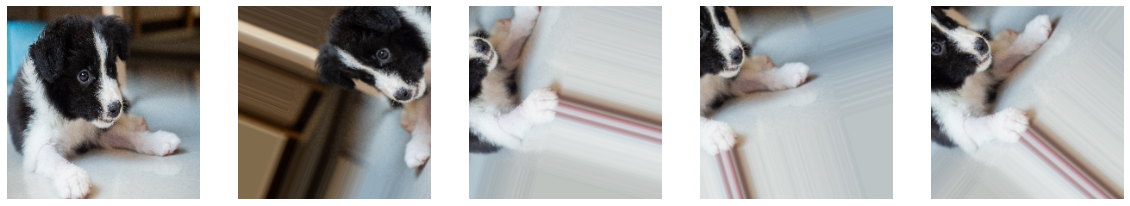

In [3]:
# 定義使用的 Augmentation
img_gen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=.5,
    height_shift_range=.5,
    shear_range=.5,
    horizontal_flip=True
)

width = 224
height = 224
batch_size = 4

img = cv2.imread('img/Tano.jpg')
img = cv2.resize(img, (width, height)) # 改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 轉成RGB

img_origin = img.copy()
img = np.array(img, dtype=np.float32)
# 輸入 generator 要是四維，(224,224,3) 變成(4,224,224,3)
img_combine = np.array([img, img, img, img], dtype=np.uint8)

# 生成圖片批次
batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape == (batch_size, width, height, 3)

plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(img_origin) # 原圖
plt.axis('off')
for i, batch in enumerate(batch_gen):
    if i > 3:
        break  # or the generator would loop infinitely
    plt.subplot(1, 5, 2+i)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.axis('off')

## 示範如何導入 ImageDataGenerator 到 Keras 訓練中
```python
#Training Generator
train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
#Test Generator，只需要Rescale，不需要其他增強
test_datagen = ImageDataGenerator(rescale = 1./255)

#將路徑給Generator，自動產生Label
training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')
    
#訓練
classifier.fit_generator(training_set,steps_per_epoch = 250,nb_epoch = 25,
                         validation_data = valid_set,validation_steps = 63)

#預測新照片
from keras.preprocessing import image as image_utils
test_image = image_utils.load_img('dataset/new_images/new_picture.jpg', target_size=(224, 224))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) 

result = classifier.predict_on_batch(test_image)
```

---

# 知識點 - 2
    
## Imgaug
Imgaug 為一個更為泛用的第三方 Library ([Github](https://github.com/aleju/imgaug))，安裝方式最簡單的話使用 `pip install imgaug`，下面我們示範用 Imgaug 做 Image augmentation。

其原理與 ImageDataGenerator 相當相似，先創建 Augmentation generator，再將圖像輸入即可。

而更為常見的方法是將多種 Augmentation 包裝在一起，甚至還可以將自己定義的 Augmentation 混合 imgaug 打造一個 pipeline

其中需要定義一個 `ImgAugSequence` 來包裝 Imgaug 中的 Augmentation，以及 `Compose` 來包裝所有的Augmentation：

另一個常見的應用在語意分割中，我們希望標籤 Mask 跟輸入影像有相同的 Augmentation(如平移、縮放)，這時候要加上 `to_deterministic()`，意思是將隨機性關閉，使訓練影像與其標籤(mask)有相同的Augmentation。

程式碼請參考底下

### 使用單項增強

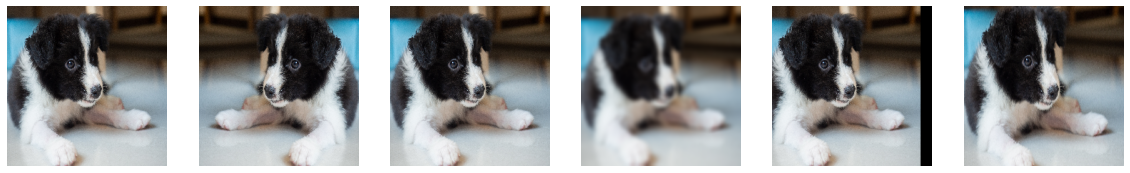

In [4]:
width = 224
height = 224

img = cv2.imread('img/Tano.jpg')
img = cv2.resize(img, (width, height)) # 改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 轉成RGB

img_origin = img.copy()
img = np.array(img, dtype=np.float32)

images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8) # 創造一個 array size==(5, 224, 224, 3)

flipper = iaa.Fliplr(1.0) # 水平翻轉機率 = 1.0
images[0] = flipper.augment_image(img)

vflipper = iaa.Flipud(0.4) # 垂直翻轉機率 = 0.4
images[1] = vflipper.augment_image(img)

blurer = iaa.GaussianBlur(3.0) # 高斯模糊圖像 (sigma of 3.0)
images[2] = blurer.augment_image(img)

translator = iaa.Affine(translate_px={"x": -16}) # 向左橫移 16 個像素
images[3] = translator.augment_image(img)

scaler = iaa.Affine(scale={"y": (0.8, 1.2)})
images[4] = scaler.augment_image(img)

# 畫圖!!!
plt.figure(figsize=(20, 10))
plt.subplot(1, 6, 1)
plt.imshow(img_origin) # 原圖

plt.axis('off')
for i, image in enumerate(images):
    plt.subplot(1, 6, 2+i)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')

---

### 打包多種Augmentation

#### 可參考Github: https://github.com/aleju/imgaug

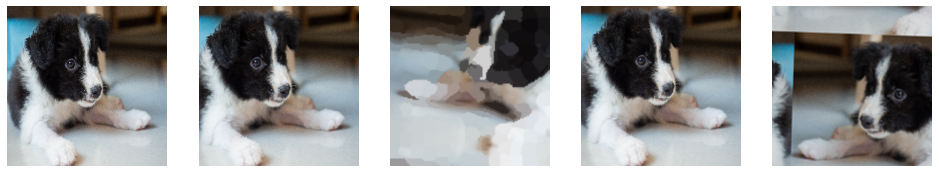

In [5]:
# 輸入照片
img = cv2.imread("img/Tano.jpg")
img = cv2.resize(img, (width, height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

img_origin = img.copy()
img = np.array(img, dtype=np.uint8)

img_combine = np.array([img, img, img, img], dtype=np.uint8)

# Sometimes(0.5, ...) 代表每次都有50%的機率運用不同的Augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# 包裝想運用的圖像增強方式
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.4),
    sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-10, 10),
        shear=(-8, 8),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL
    )),
    # convert images into their superpixel representation
    sometimes(iaa.Superpixels(
        p_replace=(0, 1.0),
        n_segments=(20, 200)
    )),
    sometimes(iaa.OneOf([
        # blur images
        iaa.GaussianBlur((0, 3.0)),
        # blur image using local means with kernel sizes between 1 and 3
        iaa.AverageBlur(k=(1, 3)),
        # blur image using local medians with kernel sizes between 3 and 5
        iaa.MedianBlur(k=(3, 5))
    ])),
    sometimes(iaa.Sharpen(
        alpha=(0, 0.2),
        lightness=(0.1, 0.4)
    )),
    sometimes(iaa.Emboss(
        alpha=(0, 0.3),
        strength=(0, 0.5)
    ))], random_order=True)

images_aug = seq.augment_images(img_combine)

# 畫圖!!!
plt.figure(figsize=(20, 10))
plt.subplot(1, 6, 1)
plt.imshow(img_origin) # 原圖

plt.axis('off')
for i, image in enumerate(images_aug):
    plt.subplot(1, 6, 2+i)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')

## 包裝自定義Augmentation 與 Imgaug Augmentation

In [6]:
"""隨機改變亮度"""
class RandomBrightness(object):
    """Function to randomly make image brighter or darker
    parameters:
        - delta: float, the bound of random.uniform distribution
    """
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta
        
    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image

"""隨機改變對比"""
class RandomContrast(object):
    """Function to strengthen or weaken the contrast in each image
    Parameters:
        - lower: float, lower bound of random.uniform distribution
        - upper: float, upper bound of random.uniform distribution
    """
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "Contrast upper must be >= lower."
        assert lower >= 0, "Contrast lower must be non-negative"
        self.lower = lower
        self.upper = upper
    
    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image

"""包裝所有Augmentation"""
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

"""包裝Imgaug"""
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence
    
    def __call__(self, image):
        image = self.sequence.augment_image(image)
        return image

class TrainAugmentations(object):
    def __init__(self):
        # define imgaug.augmenters Sequential transforms
        sometimes = lambda aug: iaa.Sometimes(0.4, aug)
        
        img_seq = iaa.Sequential([
            sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
            sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
            sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
        ], random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16),
            RandomContrast(0.9, 1.1),
            ImgAugSequence(img_seq)
        ])
        
    def __call__(self, image):
        image = self.aug_pipeline(image)
        return image

Augmenation = TrainAugmentations()

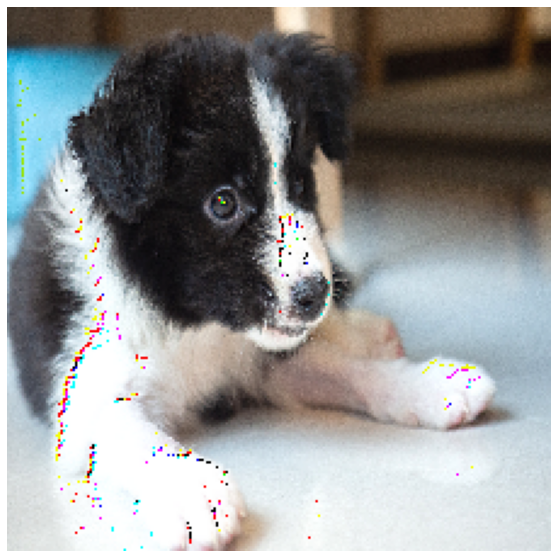

In [7]:
##輸入照片
img = cv2.imread('img/Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img = np.array(img, dtype=np.uint8)

output = Augmenation(img) 

##畫出來
plt.figure(figsize=(10,10))
for image in images_aug:
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')

## 鎖住隨機性-主要用在Semantic segmentation中

In [8]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask